## ワークスペースと実験設定

In [1]:
import azure.ai.ml 
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azureml.core import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')


try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    # This will open a browser page for
    credential = InteractiveBrowserCredential()

try:
    ml_client = MLClient.from_config(credential=credential)
except Exception as ex:
    # NOTE: Update following workspace information if not correctly configure before
    client_config = {
        "subscription_id": ws.subscription_id,
        "resource_group": ws.resource_group,
        "workspace_name": ws.name,
    }

    if client_config["subscription_id"].startswith("<"):
        print(
            "please update your <SUBSCRIPTION_ID> <RESOURCE_GROUP> <AML_WORKSPACE_NAME> in notebook cell"
        )
        raise ex
    else:  # write and reload from config file
        import json, os

        config_path = "../.azureml/config.json"
        os.makedirs(os.path.dirname(config_path), exist_ok=True)
        with open(config_path, "w") as fo:
            fo.write(json.dumps(client_config))
        ml_client = MLClient.from_config(credential=credential, path=config_path)
print(ml_client)

Found the config file in: /mnt/batch/tasks/shared/LS_root/mounts/clusters/skilling-ml2/code/Users/localdev/github/mslearn-skill2022/.azureml/config.json


In [14]:
import mlflow

tracking_uri = ml_client.workspaces.get(name=ws.name).mlflow_tracking_uri
mlflow.set_tracking_uri(tracking_uri)
experiment_name = "skill-train-evaluate-regression-models" 
mlflow.set_experiment(experiment_name)

2022/06/23 09:16:17 INFO mlflow.tracking.fluent: Experiment with name 'skill-train-evaluate-regression-models' does not exist. Creating a new experiment.


<Experiment: artifact_location='', experiment_id='65681a56-c343-4d34-8f3f-f985deeb62f8', lifecycle_stage='active', name='skill-train-evaluate-regression-models', tags={}>

## LinearRegression

### Data Prep

In [4]:
import pandas as pd
file_path = './data/daily-bike-share.csv'
bike_data = pd.read_csv(file_path)
bike_data.head()


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82


In [5]:
# Separate features and labels
X, y = bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values
print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')

Features:
[[1.        1.        0.        6.        0.        2.        0.344167
  0.363625  0.805833  0.160446 ]
 [1.        1.        0.        0.        0.        2.        0.363478
  0.353739  0.696087  0.248539 ]
 [1.        1.        0.        1.        1.        1.        0.196364
  0.189405  0.437273  0.248309 ]
 [1.        1.        0.        2.        1.        1.        0.2
  0.212122  0.590435  0.160296 ]
 [1.        1.        0.        3.        1.        1.        0.226957
  0.22927   0.436957  0.1869   ]
 [1.        1.        0.        4.        1.        1.        0.204348
  0.233209  0.518261  0.0895652]
 [1.        1.        0.        5.        1.        2.        0.196522
  0.208839  0.498696  0.168726 ]
 [1.        1.        0.        6.        0.        2.        0.165
  0.162254  0.535833  0.266804 ]
 [1.        1.        0.        0.        0.        1.        0.138333
  0.116175  0.434167  0.36195  ]
 [1.        1.        0.        1.        1.        1.        

In [6]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 511 rows
Test Set: 220 rows


### Train

In [15]:
import time 

run_name = f'sand_sklearn_LinearRegression_run_{int(time.time())}' # 実行ごとにかぶらないようにしつつ好きな名前を指定
run = mlflow.start_run(run_name=run_name)
# enable auto logging
mlflow.autolog()

2022/06/23 09:16:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/06/23 09:16:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2022/06/23 09:16:23 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.
2022/06/23 09:16:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


In [16]:
# Train the model
from sklearn.linear_model import LinearRegression

# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
print (model)

2022/06/23 09:16:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: ('cannot represent an object', OrderedDict([('name', 'mlflow-env'), ('channels', ['conda-forge']), ('dependencies', ['python=3.8.5', 'pip<=20.1.1', {'pip': ['mlflow', 'cloudpickle==1.6.0', 'lz4==4.0.1', 'psutil==5.9.0', 'scikit-learn==0.22.1', 'uuid==1.30']}])]))


### Evaluate

In [17]:
import numpy as np

predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10])

Predicted labels:  [1896. 1184. 1007.  -28.  314.  385.  475.  590. 1476.  -22.]
Actual labels   :  [2418  754  222   47  244  145  240  555 3252   38]


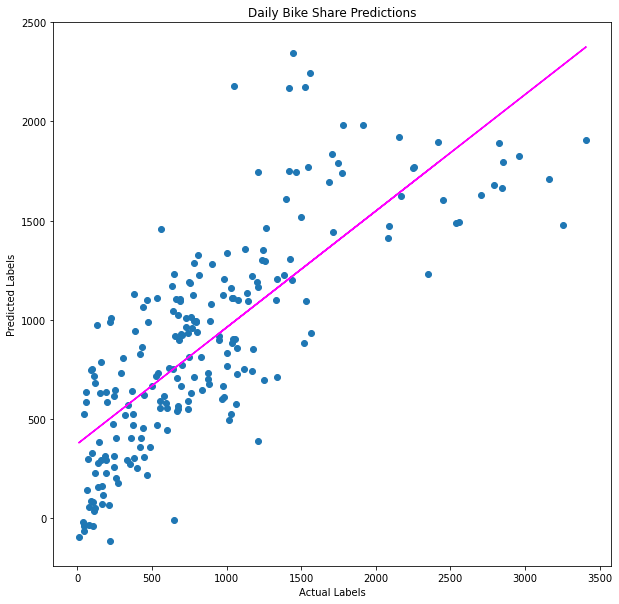

In [18]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')

mlflow.log_figure(fig,"evaluate.png")

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

metric = {
    "MSE": mse,
    "RMSE":rmse,
    "R2":r2
}
mlflow.log_metrics(metric)

MSE: 201972.55947035592
RMSE: 449.4135728595165
R2: 0.6040454736919191


In [20]:
mlflow.end_run()

## Lasso

### Train

In [22]:
import time 

run_name = f'sand_sklearn_Lasso_run_{int(time.time())}' # 実行ごとにかぶらないようにしつつ好きな名前を指定
run = mlflow.start_run(run_name=run_name)
# enable auto logging
mlflow.autolog()

2022/06/23 10:20:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/06/23 10:20:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2022/06/23 10:20:00 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.
2022/06/23 10:20:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


In [23]:
from sklearn.linear_model import Lasso

# Fit a lasso model on the training set
model = Lasso().fit(X_train, y_train)
print (model, "\n")

2022/06/23 10:20:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: ('cannot represent an object', OrderedDict([('name', 'mlflow-env'), ('channels', ['conda-forge']), ('dependencies', ['python=3.8.5', 'pip<=20.1.1', {'pip': ['mlflow', 'cloudpickle==1.6.0', 'lz4==4.0.1', 'psutil==5.9.0', 'scikit-learn==0.22.1', 'uuid==1.30']}])]))


### Evaluate

In [24]:
import numpy as np

predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10])

Predicted labels:  [1887. 1182.  967.  -31.  301.  386.  494.  600. 1445.  -16.]
Actual labels   :  [2418  754  222   47  244  145  240  555 3252   38]


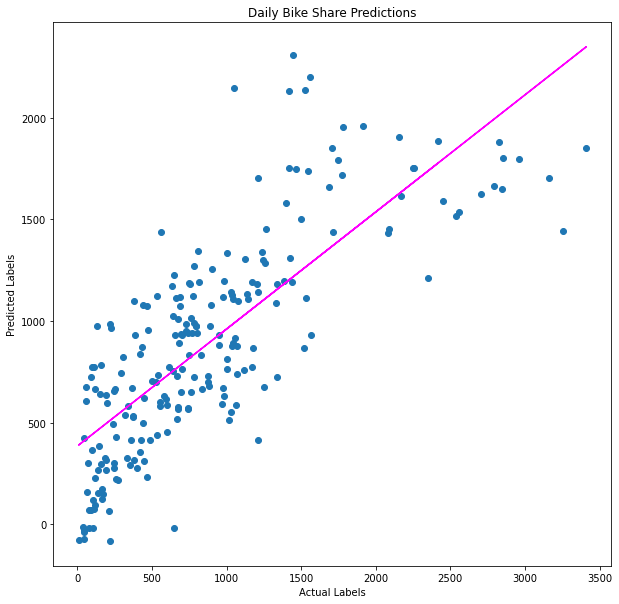

In [25]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')

mlflow.log_figure(fig,"evaluate.png")

In [26]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

metric = {
    "MSE": mse,
    "RMSE":rmse,
    "R2":r2
}
mlflow.log_metrics(metric)

MSE: 201155.70593338404
RMSE: 448.5038527519959
R2: 0.6056468637824488


In [27]:
mlflow.end_run()

## DecisionTreeRegressor

### Train

In [28]:
import time 

run_name = f'sand_sklearn_DecisionTreeRegressor_run_{int(time.time())}' # 実行ごとにかぶらないようにしつつ好きな名前を指定
run = mlflow.start_run(run_name=run_name)
# enable auto logging
mlflow.autolog()

2022/06/23 10:25:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/06/23 10:25:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2022/06/23 10:25:03 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.
2022/06/23 10:25:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

# Train the model
model = DecisionTreeRegressor().fit(X_train, y_train)
print (model, "\n")

# Visualize the model tree
tree = export_text(model)
print(tree)
mlflow.log_text(tree,"tree.txt")

2022/06/23 10:25:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: ('cannot represent an object', OrderedDict([('name', 'mlflow-env'), ('channels', ['conda-forge']), ('dependencies', ['python=3.8.5', 'pip<=20.1.1', {'pip': ['mlflow', 'cloudpickle==1.6.0', 'lz4==4.0.1', 'psutil==5.9.0', 'scikit-learn==0.22.1', 'uuid==1.30']}])]))


### Evaluate


MSE: 241830.68636363637
RMSE: 491.76283548437897
R2: 0.5259061175588766


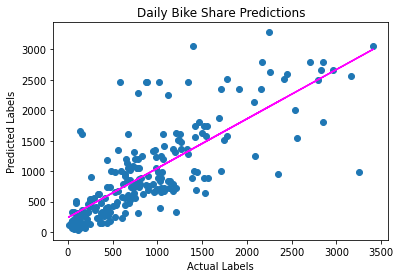

In [30]:
# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

metric = {
    "MSE": mse,
    "RMSE":rmse,
    "R2":r2
}
mlflow.log_metrics(metric)
# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
mlflow.log_figure(fig,"evaluate.png")

In [31]:
mlflow.end_run()

## RandomForestRegressor

### Train

In [37]:
import time 

run_name = f'sand_sklearn_RandomForestRegressor_run_{int(time.time())}' # 実行ごとにかぶらないようにしつつ好きな名前を指定
run = mlflow.start_run(run_name=run_name)
# enable auto logging
mlflow.autolog()

2022/06/23 10:32:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/06/23 10:32:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2022/06/23 10:32:48 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.
2022/06/23 10:32:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


In [38]:
from sklearn.ensemble import RandomForestRegressor

# Train the model
model = RandomForestRegressor().fit(X_train, y_train)
print (model, "\n")

2022/06/23 10:32:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: ('cannot represent an object', OrderedDict([('name', 'mlflow-env'), ('channels', ['conda-forge']), ('dependencies', ['python=3.8.5', 'pip<=20.1.1', {'pip': ['mlflow', 'cloudpickle==1.6.0', 'lz4==4.0.1', 'psutil==5.9.0', 'scikit-learn==0.22.1', 'uuid==1.30']}])]))


### Evaluate

MSE: 112383.13854863637
RMSE: 335.2359445952005
R2: 0.7796799104505484


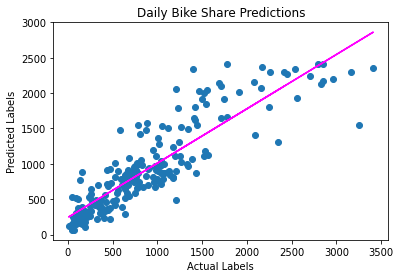

In [39]:
# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)
metric = {
    "MSE": mse,
    "RMSE":rmse,
    "R2":r2
}
mlflow.log_metrics(metric)
# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
mlflow.log_figure(fig,"evaluate.png")

In [40]:
mlflow.end_run()

## GradientBoostingRegressor

### Train

In [41]:
import time 

run_name = f'sand_sklearn_GradientBoostingRegressor_run_{int(time.time())}' # 実行ごとにかぶらないようにしつつ好きな名前を指定
run = mlflow.start_run(run_name=run_name)
# enable auto logging
mlflow.autolog()

2022/06/23 10:32:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/06/23 10:32:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2022/06/23 10:32:57 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.
2022/06/23 10:32:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


In [42]:
# Train the model
from sklearn.ensemble import GradientBoostingRegressor
# Fit a lasso model on the training set
model = GradientBoostingRegressor().fit(X_train, y_train)
print (model, "\n")


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_

### Evaluate

MSE: 104095.05599363311
RMSE: 322.63765433320566
R2: 0.7959281761093804


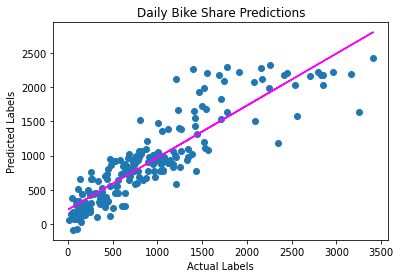

In [43]:

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)
metric = {
    "MSE": mse,
    "RMSE":rmse,
    "R2":r2
}
mlflow.log_metrics(metric)
# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
mlflow.log_figure(fig,"evaluate.png")

In [44]:
mlflow.end_run()